In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ProjectPaths import ProjectPaths

ProjectPaths.instance(r"/home/tdjg/Documents/DeepSolaris")

In [5]:
mask_images = np.load(ProjectPaths.instance().file_in_image_dir("ds_image_masks.npy"))

In [6]:
images = np.load(ProjectPaths.instance().file_in_image_dir("ds_images.npy"))

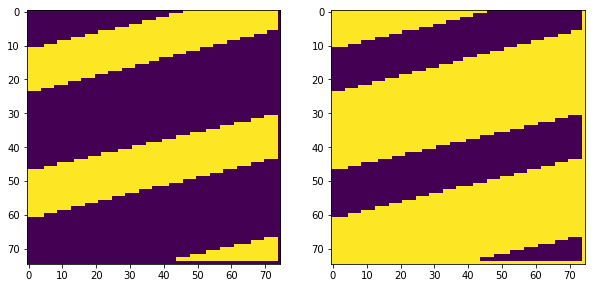

In [19]:
%matplotlib inline

def inverse_mask(mask):
    return ((mask == 0) * 255).astype(np.uint8)

_, ax = plt.subplots(1,2, figsize = (10,10))

mask = mask_images[0]
inv_mask = inverse_mask(mask)

ax[0].imshow(mask)
ax[1].imshow(inv_mask)

In [22]:
mask.dtype, inv_mask.dtype

(dtype('uint8'), dtype('uint8'))

In [23]:
inverse_masks = [inverse_mask(mask) for mask in mask_images]

In [36]:
def normalized_hist(hist_image, channel, mask=None):
    hist = cv.calcHist([hist_image], [channel], mask, [256], [0, 255])  
    number_of_pixels = hist_image.size if mask is None else mask[mask > 0].size
    return hist / number_of_pixels

def all_bands_hist(hist_image, mask=None):
    all_bands_hist = []
    for i in range(3):
        all_bands_hist.extend(normalized_hist(hist_image, i, mask))
    return np.array(all_bands_hist)

def plot_hist(hist_image, mask=None):
    normalized_counts = []
    for i, col in enumerate(["b", "g", "r"]):
        normalized_counts.append(normalized_hist(hist_image, i, mask))
        plt.plot(normalized_counts,color = col)
        plt.xlim([0,255])
    return np.array(normalized_counts)

In [43]:
positives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(images, mask_images)]).reshape(120, 768)
negatives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(images, inverse_masks)]).reshape(120, 768)

In [44]:
positives.shape, negatives.shape

((120, 768), (120, 768))

In [54]:
positive_labels = np.ones(120)
negative_labels = np.zeros(120)

In [57]:
all_histograms = np.vstack((positives, negatives))
all_labels = np.conv((positive_labels, negative_labels))

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_histograms, all_labels, test_size = 0.20)

ValueError: Found input variables with inconsistent numbers of samples: [240, 2]

In [53]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def predict(clf, X_test, y_test):
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))
    print("accuracy={}".format(accuracy_score(y_test, predictions)))
    print(confusion_matrix(y_test, predictions))

In [ ]:
predict(clf, X_test, y_test)